In [1]:
import networkx as nx
import altair as alt
import nx_altair as nxa
from nx_altair.core import to_pandas_nodes

alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [36]:
G = nx.read_gml('/mnt/data/hDHFR_modSAR_graph.gml')
pos = nx.kamada_kawai_layout(G, scale=0.7)
#pos = nx.spectral_layout(G)

In [3]:
G.nodes()['CHEMBL104787']

{'bestFold': 20,
 'community': 'm03',
 'degree': 8,
 'infomap': 'm12',
 'k': 0,
 'louvain': 'm03',
 'module': 'm03',
 'smiles': 'COc1ccc(OC)c(Cc2sc3nc(N)nc(N)c3c2C)c1',
 'threshold': 0.3}

In [11]:
comm_sort = to_pandas_nodes(G, pos)['module'].value_counts().sort_index()
comm_sort

m01      95
m02      55
m03      50
m04      47
m05      30
m06      29
m07      27
other    45
Name: module, dtype: int64

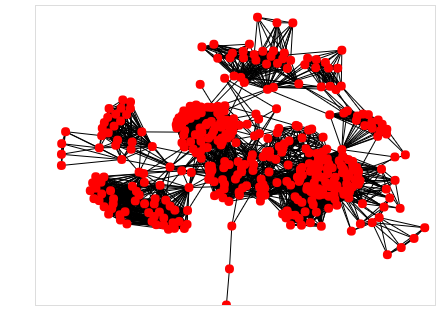

In [37]:
# Draw the graph using Altair
viz = nxa.draw_networkx(
    G=G,
    pos=pos,
    node_size=80,
    alpha=1.0)

viz.interactive()

In [20]:
alt.Scale(domain=comm_sort.index.tolist(), range=color_strong_range)

Scale({
  domain: ['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'other'],
  range: ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F']
})

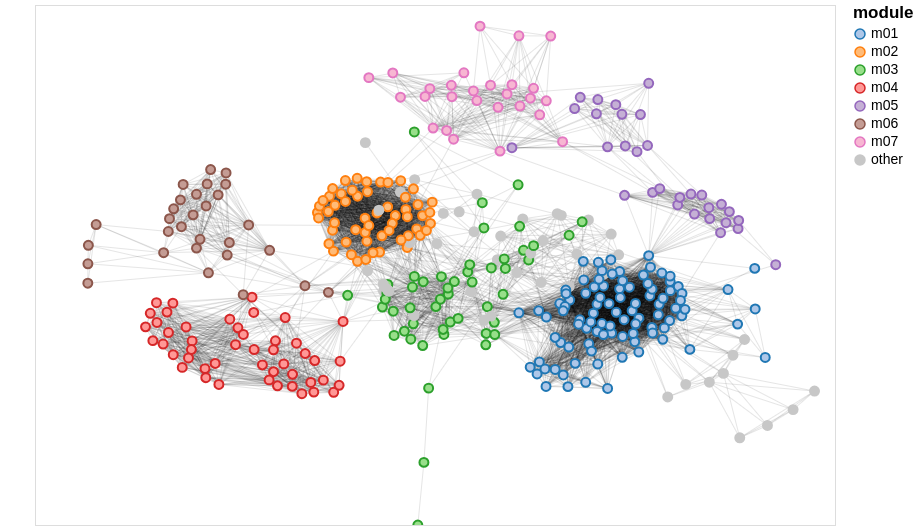

In [41]:
edges = viz.layer[0]
nodes = viz.layer[1]
color_range = ["#AEC7E8", "#FFBB78", "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7"]
color_strong_range = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B", "#E377C2", "#C7C7C7"]

edges = edges.encode(
    opacity=alt.value(0.1)
)

nodes = nodes.encode(
    stroke = alt.Color('module',
                   scale=alt.Scale(domain=comm_sort.index.tolist(),
                                   range=color_strong_range)),
    fill=alt.Color('module', 
                   scale=alt.Scale(domain=comm_sort.index.tolist(),
                                   range=color_range))
)

viz = alt.layer(edges, nodes)

viz.configure_axis(
        ticks=False,
        grid=False,
        domain=False,
        labels=False,
    ).configure_legend(
  titleFontSize=17,
  labelFontSize=14,

).properties(width=800, height=520).interactive()

# Common Core

In [69]:
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Geometry
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole 

In [46]:
molecules_df = to_pandas_nodes(G, pos)
molecules_df.head()

y louvain  k   ...   degree bestFold infomap
CHEMBL104787  -0.0814808     m03  0   ...        8       20     m12
CHEMBL10592    -0.157533     m01  0   ...       82       20     m01
CHEMBL106699  -0.0642683     m01  0   ...       74       20     m01
CHEMBL10804    -0.183385     m01  0   ...       81       20     m01
CHEMBL1080403  -0.355274     m09  0   ...        4       20     m11

[5 rows x 11 columns]

In [129]:
m01 = molecules_df[molecules_df['module'] == 'm04']
m01.head()

y louvain  k   ...   degree bestFold infomap
CHEMBL1230365  -0.258941     m04  0   ...       23       20     m03
CHEMBL1270439  -0.102685     m04  0   ...       23       20     m03
CHEMBL1270533 -0.0865456     m04  0   ...       27       20     m03
CHEMBL1270633  -0.145841     m04  0   ...       26       20     m03
CHEMBL1270734  -0.269007     m04  0   ...       30       20     m03

[5 rows x 11 columns]

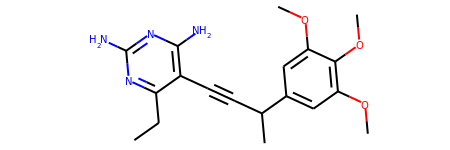

In [130]:
highest_degree_id = m01['degree'].astype(int).idxmax()
highest_degree_mol = Chem.MolFromSmiles(m01.loc[highest_degree_id]['smiles'])
highest_degree_mol

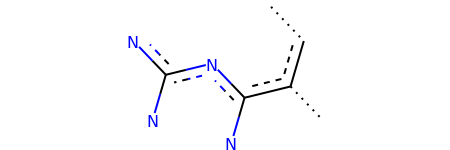

In [131]:
res=rdFMCS.FindMCS([Chem.MolFromSmiles(mol) for mol in m01['smiles']])
pattern = Chem.MolFromSmarts(res.smartsString)
pattern

In [132]:
matching = highest_degree_mol.GetSubstructMatch(pattern)

Chem.Draw.MolToFile(highest_degree_mol, 'm04_pattern.svg', size=(170, 80), highlightAtoms=matching)